In [1]:
from config import config
import pickle
import numpy as np 
import matplotlib.pyplot as plt
import skimage
import os 
from data_handling import load_dataset, unpickle
from image_feature_extraction import *
import random
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage import exposure
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import time 

%matplotlib inline

## Loading the data
The function was created in order to simplify loading the data from the restricted dataset. It is flexible, as it allows for changing the fraction of the entire dataset in the configuration file (config.ini). Thus, one can adjust it to one's needs. The folder with the restricted dataset is constructed in the same way as the original cifar10-python folder. It consists of 6 files (5 training batches + 1 test batch + 1 meta file describing the classes), which makes the further code more generalizable. <br>
A certain fraction (rounded to the next highest integer) of the total number of appearances of a label in a batch was taken from each file. This results in uneven number of representatives of particular classes. Of course it is not a problem here, especially since the deviation is less than 10 samples with 500 of them as a basis, but to be pedantic, I decided to normalize them to have the exact 10% of the entire dataset. This inconsistency is a direct result of the way I restricted the dataset. If I were to take the images from all of the training batches at once and then take 10% of each class, they would have the same number of representatives. However, in different batches there is a different number of images belonging to particular classes. 


In [2]:
restr_folder = config['paths']['restricted_dataset_path']
meta_file = os.path.join(restr_folder, config['dataset_details']['class_info'])
meta_batches = unpickle(meta_file)
class_names =[x.decode('utf-8') for x in meta_batches[b'label_names']] 
mapping_classnames = dict()
for i,value in enumerate(class_names):
    mapping_classnames[i] = value


In [18]:
train_data, train_labels, test_data, test_labels = load_images(restr_folder)

# make sure every class has the same number of instances
train_data, train_labels = even_instances(train_data, train_labels, limit=500)


In [19]:
for label in list(mapping_classnames.keys()):
    print("Number of instances of label {}: {}".format(mapping_classnames[label], len(np.where(train_labels==label)[0])))

Number of instances of label airplane: 500
Number of instances of label automobile: 500
Number of instances of label bird: 500
Number of instances of label cat: 500
Number of instances of label deer: 500
Number of instances of label dog: 500
Number of instances of label frog: 500
Number of instances of label horse: 500
Number of instances of label ship: 500
Number of instances of label truck: 500


In [20]:
print("The shape of train data: ", train_data.shape)
n_images = train_data.shape[0]
n_channels =3
#length of width and height of each image
size_image = 32
pixels_per_image = size_image * size_image * n_channels
print("There will be %d pixels per image" % pixels_per_image, " of shape ({},{},{})".format(size_image, size_image, n_channels))



The shape of train data:  (5000, 3072)
There will be 3072 pixels per image  of shape (32,32,3)


## Reshaping images 
The images are saved as 3072-dimensional vectors. In order to visualize them and retrieve some of its features, we need to reshape them. The resulting shape corresponds to the width and the height of an image (32x32) and the number of color channels (\{r,g,b\}=3). Furthermore, the initial values of the pixels are represented as ints. This, however, does not lead to the best visualization. Let's transform one of the images on the go and see how it looks like.

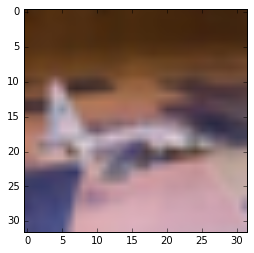

In [75]:
exemplary_img = train_data[0]
destination_img = np.zeros(size_image*size_image*n_channels)
for i in range(n_channels):
    channel_values = exemplary_img[i*size_image*size_image:(i+1)*size_image*size_image]
    destination_img[i::n_channels] = channel_values
destination_img = skimage.img_as_float(destination_img)
destination_img = destination_img.reshape((size_image,size_image,n_channels))
plt.imshow(destination_img)

On the other hand, after changing the representation from int to float, the image looks more appealing. 

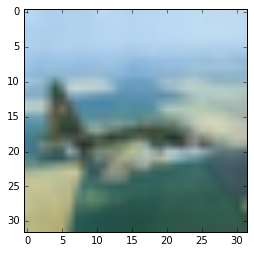

In [36]:
train_data_reshaped = reshape_images(train_data, size_image, n_channels)
plt.imshow(train_data_reshaped[0])

## Plot 10 random representatives of each label
The next step in the analysis consists of plotting 10 random representatives of each label. This is achieved by finding the indices for each label and then taking the random 10 of them. The visualization is presented in a grid.

In [80]:
random_images = {}
for i in list(np.unique(train_labels)):
    random.seed(i)
    indices_class = np.where(train_labels == i)[0]
    random.shuffle(indices_class)
    random_images[i] = train_data_reshaped[indices_class[:10],:]
    

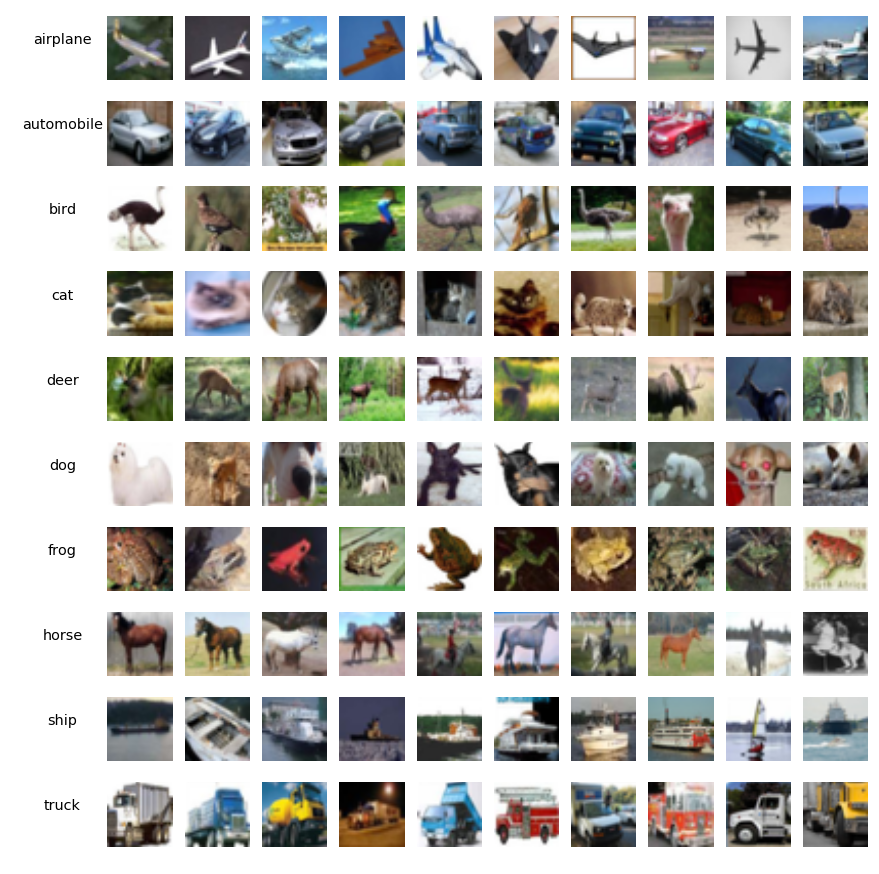

In [81]:
#plotting the 10 random images along with their categories
fig, axes = plt.subplots(nrows=len(mapping_classnames.keys()), ncols=len(mapping_classnames.keys())+1, squeeze=False, figsize=(15,15))

for i in mapping_classnames.keys():
    for j in range(len(random_images[i])):
        ax = axes[i, j+1]
        ax.axis('off')
        plt.sca(ax)
        plt.imshow(random_images[i][j])

    ax = axes[i, 0]
    plt.rcParams.update({'font.size': 12})
    ax.set_title(mapping_classnames[i], y=0.5)
    ax.axis('off')
    plt.sca(ax)



## Feature extraction - shallow classifier
The next step in this task is to train a shallow classifier that will aim to correctly classify images. To make it work, however, we first need some features that will represent the images in a meaningful and discriminative way. 
<br>
In this task, I made the following choices: 
- I decided to introduce 3 feature schemes (mean color of the image, HoG of the image, combined mean color + HoG). At first, I was also considering the raw pixels (no features), but knowing that I wanted to do parameter optimization and cross validation, I decided to leave this one out (especially since it cosists of 3072 dimensions and one fold for that in the preliminary phase lasted ~3 minutes)
- I decided to train it on an SVM shallow classifier with GridSearch that explores parameters for: kernel (linear or poly), c (1,10,100) and gamma (1e-1, 1e-3, 1e-5). 
- I introduced the random classifier, which basically predicts a random label all the time (ultimate baseline). 

<br>
At last, results for each variant of features will be considered to find the best combination of features and algorithm's parameters.  


In [85]:
#feature extraction - mean color
train_data = train_data_reshaped
features_average_color = np.array([extract_mean_color(img) for img in train_data])

Visualization of the mean color for an image:

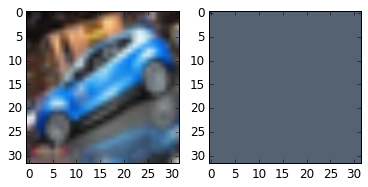

In [86]:
#visualization of the mean features
fig, axes = plt.subplots(1,2)
random.seed(100)
ex_img = random.randint(0,train_data.shape[0]-1)
axes[0].imshow(train_data[ex_img])
axes[1].imshow(np.full((32,32,3), features_average_color[ex_img]))

### Histograms of Gradients
The reason behind using HoG features is explained in the report. Here, I would like to state that the parameters for hog were chosen arbitrarily. I experimented with various settings, especially with more orientations and less pixels per cell and cells per block. For instance, setting orientations to 12 and pixels per cell to 2,2, would result in a representation of a higher quality (the gradients were more distinctive on the visualization and captured the shape of the object better). On the other hand, this is again a trade-off - the resulting vector had over 30000 dimensions and thus was not suitable for the further training and cross-validation. 
<br>
For this reason, I decided to accept somewhat lower quality, but keep a feature vector at reasonable 144 dimensions.
<br><br>
Below, there is a visualization of an image and the corresponding visualization of HoGs in lower quality (the first one) and higher quality (the second one). 

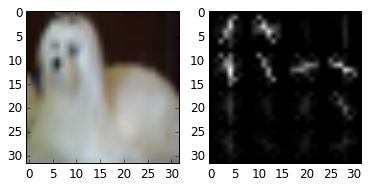

In [95]:
#second -> hog - histogram of oriented gradients 
#no gaussian smoothing - but that's because the images are blurry themselves
grayscale_train_data = np.array([rgb2gray(img) for img in train_data])
hog_features = np.array([hog(img, transform_sqrt=True, orientations=9, pixels_per_cell=(8,8), cells_per_block=(4,4), block_norm='L2', visualise=False) for img in grayscale_train_data])

fig, axes = plt.subplots(1,2)
random.seed(1000)
ex_img = random.randint(0,train_data.shape[0]-1)
axes[0].imshow(train_data[ex_img])
axes[1].imshow(exposure.rescale_intensity(hog(grayscale_train_data[ex_img], transform_sqrt=True, orientations=9, pixels_per_cell=(8,8), cells_per_block=(4,4), block_norm='L2', visualise=True)[1], in_range=(0,10)), cmap='gray')

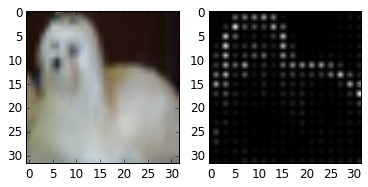

In [94]:
#the same image but with higher quality
fig, axes = plt.subplots(1,2)
random.seed(1000)
ex_img = random.randint(0,train_data.shape[0]-1)
axes[0].imshow(train_data[ex_img])
axes[1].imshow(exposure.rescale_intensity(hog(grayscale_train_data[ex_img], transform_sqrt=True, orientations=12, pixels_per_cell=(2,2), cells_per_block=(4,4), block_norm='L2', visualise=True)[1], in_range=(0,10)), cmap='gray')


In [97]:
print("Shape of the second visualization: ",hog(grayscale_train_data[ex_img], transform_sqrt=True, orientations=12, pixels_per_cell=(2,2), cells_per_block=(4,4), block_norm='L2').shape)

Shape of the second visualization:  (32448,)


#### Preparation for training
Here, I am checking if the normalization is needed (if the features of average color and HoG are in the same range). If they were not, a normalization had to be performed (each value divided by a mean value of a feature and divided by the standard deviation of a feature to result in mean=0 and var=1). The reason why normalization is important is that if we have different scales of features, it is possible that a change in one of them with high values will influence the prediction much more than a change in the feature that has small values. 

In [98]:
#concatenating feature vectors 
print("Average color features shape: {}".format(features_average_color.shape))
print("HoG features shape: {}".format(hog_features.shape))
features_concat = np.concatenate((features_average_color, hog_features), axis=1)
print("Concatenated features shape: {}".format(features_concat.shape))

#checking out if I need normalization
print("Min of avg color features: {}".format(np.min(features_average_color)))
print("Max of avg color features: {}".format(np.max(features_average_color)))
#checking out if I need normalization
print("Min of hog features: {}".format(np.min(hog_features)))
print("Max of hog features: {}".format(np.max(hog_features)))
print("No normalization is needed")
#turns out they are within the same range, so no normalization is needed 



Average color features shape: (5000, 3)
HoG features shape: (5000, 144)
Concatenated features shape: (5000, 147)
Min of avg color features: 0.035213694852941416
Max of avg color features: 0.9647365196078442
Min of hog features: 0.0
Max of hog features: 0.8047974432760251
No normalization is needed


#### Introducing classifiers and settings for the grid-search&cross-validation
In the following cells, I introduce two classifiers (random and SVM), along with the parameters for the Grid Search. 
<br>
The aim of the grid search is to train the classifier with the specified parameters in order to find the best set of parameters. Additionally, we introduce cross-validation (which is not introduced by default). Thanks to this, the results will be more generalizable (the description of the parameters and cross-validation is present in the report). The grid search is performed on 3 cores (I have a 4 core machine), which makes it faster. 

In [99]:
#grid search for parameters tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

#INTRODUCING CLASSIFIERS:
#create a random classifier
#1. Random classifier - just predicts the random class - the same as majority classifier because the number of instances of all labels is the same
def random_classifier(data, labels):
    unique_labels = list(np.unique(labels))
    return [random.choice(unique_labels) for x in range(data.shape[0])]

#create a proper shallow classifier
#2. SVM - parameters estimation will be performed with GridSearch & cross-val

#c - how much I want to avoid misclassifying EACH example - large c, small margin, less misclassifications
#gamma - how far the influence of a single training example reaches
#for kernel - i am not using rbf, because even though it is more flexible, it also is more prone to overfitting (and also takes more time to compute)
parameters = {'kernel': ['linear', 'poly'], 'gamma': [1e-1,1e-3, 1e-5],'C': [1, 10, 100]}

classifiers = ['random', 'svm']
features_selection = {
    'hog': hog_features,
    'avg': features_average_color,
    'combined': features_concat
}

##### About the metric
The preliminary metric for choosing the best classifier and the best parameters will be accuracy. The reason for choosing accuracy here is that it is easy to compare it across the trials. In case of other metrics, one would need to take a look at outcomes for different classes and perhaps prioritize some over the others. 
<br>Once the parameters will be chosen, a more detailed evaluation on the test set will be performed.

In [107]:
classification_results={}

start_time = time.time()
for features in list(features_selection.keys()):
    print("Current feature: {}".format(features))
    train_data = features_selection[features]
    classification_results[features] = {}
    for classifier in classifiers:
        classification_results[features][classifier] = {}
        if classifier == 'random':
            rand_indices = np.array(random.sample(list(range(len(train_data))), 500))
            prediction = random_classifier(train_data[rand_indices,:], train_labels[rand_indices])
            prediction_score = accuracy_score(train_labels[rand_indices], prediction)
        elif classifier == 'svm': 
            svm = SVC()
            gridsearch = GridSearchCV(svm, parameters, cv=5, n_jobs=3, scoring='accuracy', verbose=1)
            gridsearch.fit(train_data, train_labels)
            best_params = gridsearch.best_params_
            prediction_score = gridsearch.best_score_
            classification_results[features][classifier]['best_score'] = prediction_score
        classification_results[features][classifier]['params'] = best_params
        print("Classifier {} computed".format(classifier))
    print("Feature {} classified".format(features))
end_time = time.time()
print("Finished in {} seconds".format(end_time-start_time))

Current feature: hog
Classifier random computed
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:  7.1min finished


Classifier svm computed
Feature hog classified
Current feature: combined
Classifier random computed
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:  7.4min finished


Classifier svm computed
Feature combined classified
Current feature: avg
Classifier random computed
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.9s
[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:   54.9s finished


Classifier svm computed
Feature avg classified
Finished in 939.0266759395599 seconds


In [108]:
print(classification_results)
print(gridsearch.best_params_)

{'hog': {'random': {'params': {'gamma': 0.1, 'C': 10, 'kernel': 'linear'}, 'best_score': 0.13800000000000001}, 'svm': {'params': {'gamma': 0.1, 'C': 1, 'kernel': 'linear'}, 'best_score': 0.46800000000000003}}, 'combined': {'random': {'params': {'gamma': 0.1, 'C': 1, 'kernel': 'linear'}, 'best_score': 0.11}, 'svm': {'params': {'gamma': 0.1, 'C': 100, 'kernel': 'poly'}, 'best_score': 0.50160000000000005}}, 'avg': {'random': {'params': {'gamma': 0.1, 'C': 100, 'kernel': 'poly'}, 'best_score': 0.10000000000000001}, 'svm': {'params': {'gamma': 0.1, 'C': 10, 'kernel': 'linear'}, 'best_score': 0.22339999999999999}}}
{'gamma': 0.1, 'C': 10, 'kernel': 'linear'}


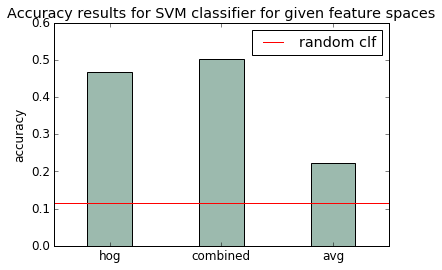

In [152]:
#plot the results of the classifiers
best_results = []
features = []
random = []
for (key,value) in classification_results.items():
    features.append(key)
    best_results.append(value['svm']['best_score'])
    random.append(value['random']['best_score'])
random = np.average(random)
width=0.4
x = np.arange(len(features))
x_2 = np.arange(4)
plt.xlim(-0.5,2.5)
plt.xticks(x, features)
plt.ylabel("accuracy")
plt.title("Accuracy results for SVM classifier for given feature spaces")
plt.bar(x-0.2, height=best_results, width=width, color="#9cbaae")
plt.plot(x_2-0.5, [random for i in x_2], color='red', label='random clf')
plt.legend()
plt.show()

#### Short discussion
As one can see, all of the features seem to be meaningful and improving the correct recognition of the images. Even the mean color can lead to twice as good predictions as random classifier. The best results were obtained for the combined features variant and it will be used in the final evaluation part. The parameters that yielded the best score are:
- c:100
- gamma: 0.1
- kernel: poly

In [154]:
best_feature = features[np.argmax(best_results)]
best_params = classification_results[best_feature]['svm']['params']
print(best_params)

{'gamma': 0.1, 'C': 100, 'kernel': 'poly'}


In [155]:
#feature extraction for the test set
test_data = reshape_images(test_data, size_image, n_channels)
test_avg_color = np.array([extract_mean_color(img) for img in test_data])
grayscale_test_data = np.array([rgb2gray(img) for img in test_data])
test_hog_features = np.array([hog(img, transform_sqrt=True, orientations=9, pixels_per_cell=(8,8), cells_per_block=(4,4), block_norm='L2', visualise=False) for img in grayscale_test_data])
test_features_concat = np.concatenate((test_avg_color, test_hog_features), axis=1)


#### Training and prediction on the test set


In [157]:
svm = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])

svm.fit(features_concat, train_labels)
predictions = svm.predict(test_features_concat)



#### Evaluation metrics
Here, the following metrics will be introduced:
- accuracy
- f1
- precision
- recall

In [172]:
print(classification_report(test_labels, predictions))

             precision    recall  f1-score   support

          0       0.64      0.49      0.56       100
          1       0.52      0.69      0.59       100
          2       0.42      0.34      0.38       100
          3       0.36      0.37      0.37       100
          4       0.44      0.48      0.46       100
          5       0.45      0.43      0.44       100
          6       0.56      0.69      0.62       100
          7       0.66      0.61      0.64       100
          8       0.55      0.61      0.58       100
          9       0.61      0.48      0.54       100

avg / total       0.52      0.52      0.52      1000



The results are discussed in the report

In [173]:
cat_label = 0
for x in mapping_classnames.keys():
    if mapping_classnames[x] == 'cat':
        cat_label = x

cat_test_set = test_features_concat[np.where(test_labels == cat_label)]
cat_test_label = test_labels[np.where(test_labels == cat_label)]

cat_predictions = svm.predict(cat_test_set)
print(classification_report(cat_test_label, cat_predictions))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00         0
          2       0.00      0.00      0.00         0
          3       1.00      0.37      0.54       100
          4       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
          7       0.00      0.00      0.00         0
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         0

avg / total       1.00      0.37      0.54       100



/Users/admin/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [174]:
import torch

In [ ]:
torch.set_num_threads()